# Grid World

By: James Nesfield

Last Edited: 3/22/2022

Purpose: The purpose of this notebook is to explore the gridworld problem.

Items reviewed here are from Chapter 4 covering Dynamic Programming in Reinforcement Learning; An Introduction by Sutton and Barto:
- Iterative Policy Estimation, for estimating V ≈ v <sub> π
- Policy Iteration (using iterative policy evaluation) for estimating π ≈ π <sub> *
- Value Iteration, for estimating π ≈ π <sub> *
    
Objects to create:
- Base Environment Obj
- Iterative Policy Est Obj
- Policy Iteration Obj
- Value Iteration Obj   

## Import Libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.table import Table
import numpy as np

## Base Environment Object

In [2]:
#define environment object
class environment():
    def __init__(self, dims = 4, terminals = [[0,0],[3,3]], reward = -1):
        """
        this class initializes the environment
        
        inputs
        dims - a scalar to define a dxd grid environment
        terminals - a list of lists of ordered pairs representing the location in the grid of the terminal states
        reward -  the reward value for moving one space (unless in a terminal state)
        
        self defined variables
        actions - determines actions that can be taken in the environment where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        None
        """
        self.dims = dims
        self.terminals = terminals
        self.reward = reward
        self.actions = [np.array([0, -1]),
                       np.array([-1, 0]),
                       np.array([0, 1]),
                       np.array([1, 0])]
    
    def is_terminal(self,i,j):
        """
        This function checks if coordinates are for a terminal state
        
        inputs
        i = y coord (row)
        j = x coord (col)
        
        returns
        boolean on terminal status
        """
        return [i,j] in self.terminals
        
        
    def next_state(self,i,j,a):
        """
        this function determines the next state and the reward received
        This function also checks if current state is terminal, or next state is terminal
        This function will also bounce back to the original coordinates if it is an edge/border square in the grid
        
        inputs
        i = y coord (row)
        j = x coord (col)
        a = action taken where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        i_next, j_next representing next state coordinates
        reward received for moving
        """
        # check if current state is terminal, if so return current state and reward = 0
        if self.is_terminal(i,j):
            return i, j, 0
        
        # get next state
        next = [i,j] + self.actions[a]
        
        #check if next state is outside boundries of the grid
        
        if next[0] < 0 or next[1] <0:
            return i, j, self.reward
        elif next[0] > (self.dims-1) or next[1] > (self.dims-1):
            return i, j, self.reward
        else:
            return next[0], next[1], self.reward

    def draw_image(self, state_values):
        """
        This function draws out the state value representation of the grid
        
        inputs
        state_values - np array of state values
        
        returns
        matplotlib drawing of the state values
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = state_values.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(state_values):
            tb.add_cell(i, j, width, height, text=round(val,2),
                        loc='center', facecolor='white')

            # Row and column labels...
        for i in range(len(state_values)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')
        ax.add_table(tb)       


# Iterative Policy Estimation, for estimating V ≈ v <sub> π
 
 <br>   
 <strong>From Reinforcement Learning; An Introduction by Sutton and Barto:</strong><br>
    
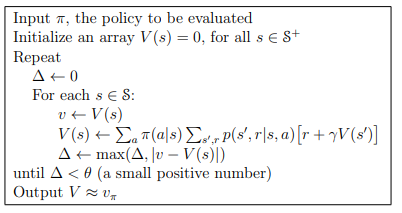

In [3]:
class iterative_policy_estimation():
    def __init__(self, dims = 4, terminals = [[0,0],[3,3]], reward = -1, iterations = 3, theta = 1, gamma = .75):
        
        """
        this class initializes the iterative policy estimation object
        this class does not do inplace updates which would be another object later
        
        inputs
        dims - a scalar to define a dxd grid environment
        terminals - a list of lists of ordered pairs representing the location in the grid of the terminal states
        reward -  the reward value for moving one space (unless in a terminal state)
        iterations - the number of policy iterations to process
        theta - the change required to exit the policy update loop in the algo
        gamma - the discount factor used in value estimation
        
        self defined variables
        actions - determines actions that can be taken in the environment where 1 = left, 2 = up, 3 = right, 4 = down
        
        returns
        None
        """
        #internal variables
        self.dims = dims
        self.terminals = terminals
        self.reward = reward
        self.iterations = iterations
        self.theta = theta
        self.gamma = gamma
        
        #define random policy
        self.policy = 1/4 * np.ones((dims, dims, 4))
        
        #set terminal state policy values to zero (take no actions)
        for term in self.terminals:
            self.policy[term[0],term[1]] = [0,0,0,0]
        
        #initialize environment
        self.environment = environment(self.dims, self.terminals, self.reward)
        
        #initialize state values
        self.state_values = np.zeros((dims, dims))
        
        #iterate thru policy estimation
        for i in range(self.iterations):
            self.state_values = self.policy_estimation(self.policy, self.state_values, self.theta, self.gamma, self.environment)
            
        #display results
        self.environment.draw_image(self.state_values)
        
    def policy_estimation(self, policy, state_values, theta, gamma, environment):
        """
        This function does value estimation based on the state_values, theta, and environment given
        
        inputs
        policy - the policy to determine values from
        state_values - np array of state_values
        theta - the change required to exit the policy update loop in the algo
        gamma - the discount factor used in value estimation
        enviornment - the grid object we are working thru to discern the state_value representation of the problem
        
        outputs
        the updated state_values numpy array
        """
        
           
        # enter infinite loop that breaks once delta is less than theta
        while True:
            #copy state into temp holder
            old_state = state_values.copy()
            
            #set delta to 0
            internal_delta = 0
                      
            #iterate thru values (for each state in states):
            for (i, j), val in np.ndenumerate(state_values):
                
                state_policy = policy[i,j]
                
                new_value = 0
                
                #iterate thru actions
                for a in range(4):
                    
                    #check if policy dictates take no action (such as in terminal states)
                    if state_policy[a] <= 0:
                        continue
                    else:
                        next_state_i, next_state_j, reward = environment.next_state(i,j,a)
                        new_value = new_value + state_policy[a] * (reward + gamma * old_state[next_state_i, next_state_j])
                        state_values[i,j] = new_value

            #check if max (internal_delta, abs(old_val - new_value)) < theta
            if max(internal_delta, abs(old_state - state_values).max()) < theta:
                return state_values
                        
                
        

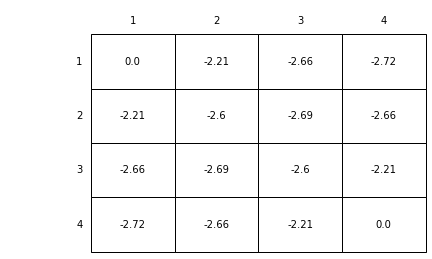

In [4]:
iterative_policy_estimation()

# Policy Iteration (using iterative policy evaluation) for estimating π ≈ π <sub> *
    
<br>   
<strong>From Reinforcement Learning; An Introduction by Sutton and Barto:</strong><br>
    
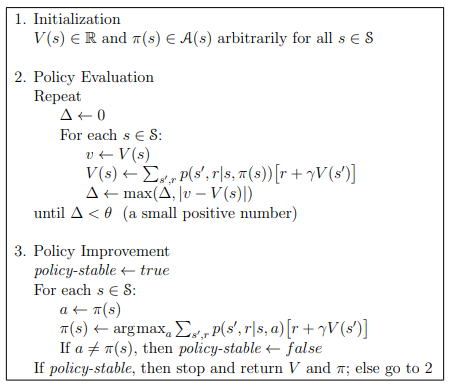

In [5]:
class policy_iteration():
    def __init__(self, dims = 4, terminals = [[0,0],[3,3]], reward = -1, iterations = 4, theta = 1, gamma = .75):
        
        """
        this class initializes the iterative policy estimation object
        this class does not do inplace updates which would be another object later
        
        inputs
        dims - a scalar to define a dxd grid environment
        terminals - a list of lists of ordered pairs representing the location in the grid of the terminal states
        reward -  the reward value for moving one space (unless in a terminal state)
        iterations - the number of policy iterations to process
        theta - the change required to exit the policy update loop in the algo
        gamma - the discount factor used in value estimation
        
        self defined variables
        actions - determines actions that can be taken in the environment where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        None
        """
        #internal variables
        self.dims = dims
        self.terminals = terminals
        self.reward = reward
        self.iterations = iterations
        self.theta = theta
        self.gamma = gamma
        
        #set policy stability flag to false
        self.policy_stable = False
        
        #define random policy
        self.policy = 1/4 * np.ones((dims, dims, 4))
        
        #set terminal state policy values to zero (take no actions)
        for term in self.terminals:
            self.policy[term[0],term[1]] = [0,0,0,0]
        
        #initialize environment
        self.environment = environment(self.dims, self.terminals, self.reward)
        
        #initialize state values
        self.state_values = np.zeros((dims, dims))
        
        #iterate thru policy iteration
        for i in range(self.iterations):
            
            #print("policy improvement loop:" ,i)
            
            #value_estimation based on policy:
            self.state_values = self.policy_estimation(self.policy, self.state_values, self.theta, self.gamma, self.environment)
            
            self.policy, self.policy_stable = self.policy_update(self.policy, self.state_values, self.environment)
            
        #display results
        self.environment.draw_image(self.state_values)
        
        #print("final policy check:", self.policy)
        #write final policy for each state
        self.write_actions(self.policy)
        
    def policy_estimation(self, policy, state_values, theta, gamma, environment):
        """
        This function does value estimation based on the state_values, theta, and environment given
        
        inputs
        policy - the policy to determine values from
        state_values - np array of state_values
        theta - the change required to exit the policy update loop in the algo
        gamma - the discount factor used in value estimation
        enviornment - the grid object we are working thru to discern the state_value representation of the problem
        
        outputs
        the updated state_values numpy array
        """
        
           
        # enter infinite loop that breaks once delta is less than theta
        while True:
            #copy state into temp holder
            old_state = state_values.copy()
            
            #set delta to 0
            internal_delta = 0
                      
            #iterate thru values (for each state in states):
            for (i, j), val in np.ndenumerate(state_values):
                
                state_policy = policy[i,j]
                
                new_value = 0
                
                #iterate thru actions
                for a in range(4):
                    
                    #check if policy dictates take no action (such as in terminal states)
                    if state_policy[a] <= 0:
                        continue
                    else:
                        next_state_i, next_state_j, reward = environment.next_state(i,j,a)
                        new_value = new_value + state_policy[a] * (reward + gamma * old_state[next_state_i, next_state_j])
                        state_values[i,j] = new_value

            #check if max (internal_delta, abs(old_val - new_value)) < theta
            if max(internal_delta, abs(old_state - state_values).max()) < theta:
                return state_values
            
    def policy_update(self, policy, state_values, environment):
        """
        This function updates the policy given the state values passed to it
        This is taking the greedy approach with no exploration
        
        inputs
        policy - the policy to determine values from
        state_values - np array of state_values
        enviornment - the grid object we are working thru to discern the state_value representation of the problem
        
        outputs
        the updated policy numpy array
        the policy stable flag
        """
        policy_stable = True
        
        #print("check state vals:",state_values)
        
        #cycle thru state values
        for (i, j), val in np.ndenumerate(state_values):
            #print("debug coords:", i, j)
                      
            old_policy = policy.copy()
            
            state_policy = policy[i,j]
            
            action_values = np.zeros((4))
            
            if environment.is_terminal(i,j):
                policy[i,j] = action_values
                #print("terminal state")
                continue
                
            
            
            #iterate thru actions
            for a in range(4):

                #check if policy dictates take no action (such as in terminal states)
                if state_policy[a] <= 0:
                    action_values[a] = -1 * np.inf
                    
                     
                else:
                    next_state_i, next_state_j, reward = environment.next_state(i,j,a)
                    if state_values[next_state_i, next_state_j] == 0:
                        action_values[a] = 1
                    else:
                        action_values[a] = state_values[next_state_i, next_state_j]
                              
            #debug
            #print("action value debug:",action_values)
            
            #set up dummy array to caputre action update
            dummy_array = np.zeros((4))
            
            #print("check best value", dummy_array[np.argsort(action_values)[-1]])
            
            ##############################################################################
            
            
            #check if all have equal values
            if all(ele == action_values[0] for ele in action_values): 
                #print("all action values match")
                dummy_array = 1/4 * np.ones((4))
            
            #check if 3 have equal values
            elif (action_values[np.argsort(action_values)[-1]] == action_values[np.argsort(action_values)[-2]] and action_values[np.argsort(action_values)[-1]] == action_values[np.argsort(action_values)[-3]]):
                #print("three action values match")
                dummy_array = 1/3 * np.ones((4))
                dummy_array[np.argsort(action_values)[0]] = 0
             
            #check if two have equal values
            elif action_values[np.argsort(action_values)[-1]] == action_values[np.argsort(action_values)[-2]]:
                #print("two action values match")
                dummy_array[np.argsort(action_values)[-1]] = .5
                dummy_array[np.argsort(action_values)[-2]] = .5
            
            #otherwise pick best value
            else:
                #print("there can be only one")
                dummy_array[np.argsort(action_values)[-1]] = 1 
           
            #update policy
            #print(dummy_array)
            policy[i,j] = dummy_array
         
        #check if policy is stable where policy is not changing
        if (policy != old_policy).all:
            #print("check policy stability,",(policy != old_policy).all)
            policy_stable = False
        
        #print("check policy:", policy)
        #print(policy_stable)
        return policy, policy_stable
            
    def write_actions(self, policy):
                
        """
        this function takes the policy and prints out what actions to take in each state
        
        inputs
        policy - the final policy derived in policy iteration
        
        outputs
        std out print of the data
        """
        
        for i in range(self.dims):
            for j in range(self.dims):
                print("state x:", j, "\t y:",i)

                actions = ""
                if policy[i,j][0] > 0:
                    actions += " left "

                if policy[i,j][1] > 0:
                    actions += " up "

                if policy[i,j][2] > 0:
                    actions += " right "

                if policy[i,j][3] > 0:
                    actions += " down "
                print("actions:" ,actions)
            

state x: 0 	 y: 0
actions: 
state x: 1 	 y: 0
actions:  left 
state x: 2 	 y: 0
actions:  left 
state x: 3 	 y: 0
actions:  left  down 
state x: 0 	 y: 1
actions:  up 
state x: 1 	 y: 1
actions:  left  up 
state x: 2 	 y: 1
actions:  left  up  right  down 
state x: 3 	 y: 1
actions:  down 
state x: 0 	 y: 2
actions:  up 
state x: 1 	 y: 2
actions:  left  up  right  down 
state x: 2 	 y: 2
actions:  right  down 
state x: 3 	 y: 2
actions:  down 
state x: 0 	 y: 3
actions:  up  right 
state x: 1 	 y: 3
actions:  right 
state x: 2 	 y: 3
actions:  right 
state x: 3 	 y: 3
actions: 


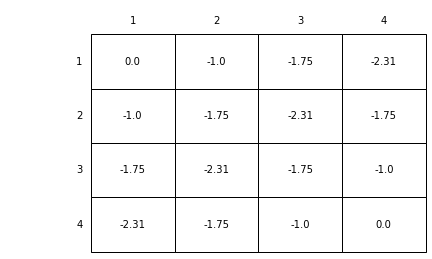

In [6]:
policy_iteration()

# Value Iteration, for estimating π ≈ π <sub> *
    
<br>   
<strong>From Reinforcement Learning; An Introduction by Sutton and Barto:</strong><br>

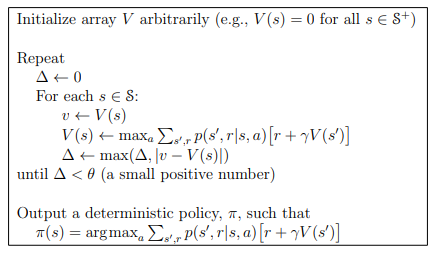

In [7]:
class value_iteration():
    def __init__(self, dims = 4, terminals = [[0,0],[3,3]], reward = -1, theta = .5, gamma = .75):
        
        
        """
        this class initializes the iterative policy estimation object
        this class does not do inplace updates which would be another object later
        
        inputs
        dims - a scalar to define a dxd grid environment
        terminals - a list of lists of ordered pairs representing the location in the grid of the terminal states
        reward -  the reward value for moving one space (unless in a terminal state)
        iterations - the number of policy iterations to process
        theta - the change required to exit the policy update loop in the algo
        gamma - the discount factor used in value estimation
        
        self defined variables
        actions - determines actions that can be taken in the environment where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        None
        
        note
        changed theta value to .5 here to force value iteration to find better approximations
        """
        #internal variables
        self.dims = dims
        self.terminals = terminals
        self.reward = reward
        self.theta = theta
        self.gamma = gamma
        
        #set policy stability flag to false
        self.policy_stable = False
        
        #define random policy
        self.policy = 1/4 * np.ones((dims, dims, 4))
        
        #set terminal state policy values to zero (take no actions)
        for term in self.terminals:
            self.policy[term[0],term[1]] = [0,0,0,0]
        
        #initialize environment
        self.environment = environment(self.dims, self.terminals, self.reward)
        
        #initialize state values
        self.state_values = np.zeros((dims, dims))
                   
        #value_estimation based on policy:
        self.state_values = self.policy_estimation(self.policy, self.state_values, self.theta, self.gamma, self.environment)
        
        #this is the same as policy iteration but values are iterated several times then the policy derived from such
        self.policy, self.policy_stable = self.policy_update(self.policy, self.state_values, self.environment)
            
        #display results
        self.environment.draw_image(self.state_values)
        
        #print("final policy check:", self.policy)
        #write final policy for each state
        self.write_actions(self.policy)
        
    def policy_estimation(self, policy, state_values, theta, gamma, environment):
        """
        This function does value estimation based on the state_values, theta, and environment given
        
        inputs
        policy - the policy to determine values from
        state_values - np array of state_values
        theta - the change required to exit the policy update loop in the algo
        gamma - the discount factor used in value estimation
        enviornment - the grid object we are working thru to discern the state_value representation of the problem
        
        outputs
        the updated state_values numpy array
        """
        
           
        # enter infinite loop that breaks once delta is less than theta
        while True:
            #copy state into temp holder
            old_state = state_values.copy()
            
            #set delta to 0
            internal_delta = 0
                      
            #iterate thru values (for each state in states):
            for (i, j), val in np.ndenumerate(state_values):
                
                state_policy = policy[i,j]
                
                new_value = 0
                
                #iterate thru actions
                for a in range(4):
                    
                    #check if policy dictates take no action (such as in terminal states)
                    if state_policy[a] <= 0:
                        continue
                    else:
                        next_state_i, next_state_j, reward = environment.next_state(i,j,a)
                        new_value = new_value + state_policy[a] * (reward + gamma * old_state[next_state_i, next_state_j])
                        state_values[i,j] = new_value

            #check if max (internal_delta, abs(old_val - new_value)) < theta
            if max(internal_delta, abs(old_state - state_values).max()) < theta:
                return state_values
            
            
    def policy_update(self, policy, state_values, environment):
        """
        This function updates the policy given the state values passed to it
        This is taking the greedy approach with no exploration
        
        inputs
        policy - the policy to determine values from
        state_values - np array of state_values
        enviornment - the grid object we are working thru to discern the state_value representation of the problem
        
        outputs
        the updated policy numpy array
        the policy stable flag
        """
        policy_stable = True
        
        #print("check state vals:",state_values)
        
        #cycle thru state values
        for (i, j), val in np.ndenumerate(state_values):
            #print("debug coords:", i, j)
                      
            old_policy = policy.copy()
            
            state_policy = policy[i,j]
            
            action_values = np.zeros((4))
            
            if environment.is_terminal(i,j):
                policy[i,j] = action_values
                #print("terminal state")
                continue
                
            
            
            #iterate thru actions
            for a in range(4):

                #check if policy dictates take no action (such as in terminal states)
                if state_policy[a] <= 0:
                    action_values[a] = -1 * np.inf
                    
                     
                else:
                    next_state_i, next_state_j, reward = environment.next_state(i,j,a)
                    if state_values[next_state_i, next_state_j] == 0:
                        action_values[a] = 1
                    else:
                        action_values[a] = state_values[next_state_i, next_state_j]
                              
            #debug
            #print("action value debug:",action_values)
            
            #set up dummy array to caputre action update
            dummy_array = np.zeros((4))
            
            #print("check best value", dummy_array[np.argsort(action_values)[-1]])
            
            ##############################################################################
            
            
            #check if all have equal values
            if all(ele == action_values[0] for ele in action_values): 
                #print("all action values match")
                dummy_array = 1/4 * np.ones((4))
            
            #check if 3 have equal values
            elif (action_values[np.argsort(action_values)[-1]] == action_values[np.argsort(action_values)[-2]] and action_values[np.argsort(action_values)[-1]] == action_values[np.argsort(action_values)[-3]]):
                #print("three action values match")
                dummy_array = 1/3 * np.ones((4))
                dummy_array[np.argsort(action_values)[0]] = 0
             
            #check if two have equal values
            elif action_values[np.argsort(action_values)[-1]] == action_values[np.argsort(action_values)[-2]]:
                #print("two action values match")
                dummy_array[np.argsort(action_values)[-1]] = .5
                dummy_array[np.argsort(action_values)[-2]] = .5
            
            #otherwise pick best value
            else:
                #print("there can be only one")
                dummy_array[np.argsort(action_values)[-1]] = 1 
           
            #update policy
            #print(dummy_array)
            policy[i,j] = dummy_array
         
        #check if policy is stable where policy is not changing
        if (policy != old_policy).all:
            #print("check policy stability,",(policy != old_policy).all)
            policy_stable = False
        
        #print("check policy:", policy)
        #print(policy_stable)
        return policy, policy_stable
            
    def write_actions(self, policy):
                
        """
        this function takes the policy and prints out what actions to take in each state
        
        inputs
        policy - the final policy derived in policy iteration
        
        outputs
        std out print of the data
        """
        
        for i in range(self.dims):
            for j in range(self.dims):
                print("state x:", j, "\t y:",i)

                actions = ""
                if policy[i,j][0] > 0:
                    actions += " left "

                if policy[i,j][1] > 0:
                    actions += " up "

                if policy[i,j][2] > 0:
                    actions += " right "

                if policy[i,j][3] > 0:
                    actions += " down "
                print("actions:" ,actions)
            

state x: 0 	 y: 0
actions: 
state x: 1 	 y: 0
actions:  left 
state x: 2 	 y: 0
actions:  left 
state x: 3 	 y: 0
actions:  left  down 
state x: 0 	 y: 1
actions:  up 
state x: 1 	 y: 1
actions:  left  up 
state x: 2 	 y: 1
actions:  left  down 
state x: 3 	 y: 1
actions:  down 
state x: 0 	 y: 2
actions:  up 
state x: 1 	 y: 2
actions:  up  right 
state x: 2 	 y: 2
actions:  right  down 
state x: 3 	 y: 2
actions:  down 
state x: 0 	 y: 3
actions:  up  right 
state x: 1 	 y: 3
actions:  right 
state x: 2 	 y: 3
actions:  right 
state x: 3 	 y: 3
actions: 


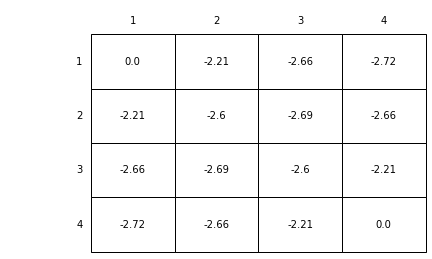

In [8]:
value_iteration()